In [3]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

C:\Users\itsha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
csv_path = os.path.join(path, 'creditcard.csv')
df = pd.read_csv(csv_path)

print("DATASET OVERVIEW")
print(df.head())

DATASET OVERVIEW
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26    

In [37]:
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values found in the dataset")
else:
    print(missing_values[missing_values > 0])

No missing values found in the dataset


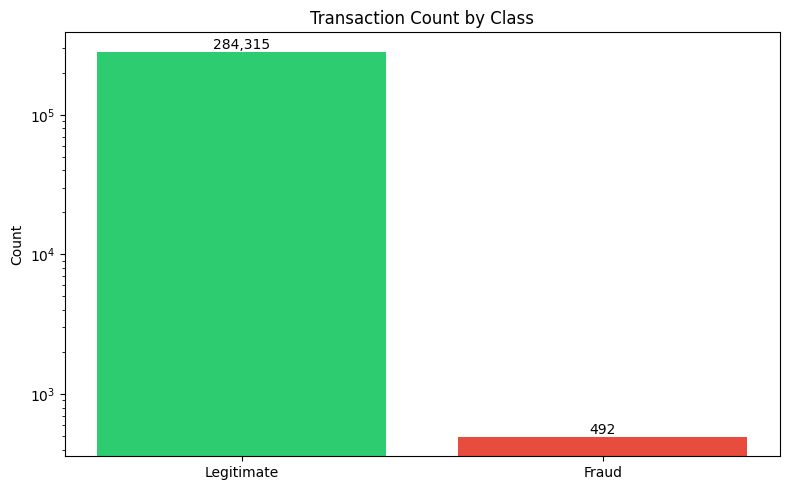

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Transaction Count by Class')
ax.set_yscale('log')
for i, v in enumerate(class_counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\itsha\AppData\Local\Temp\ipykernel_11704\3904577276.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Legitimate', 'Fraud'])


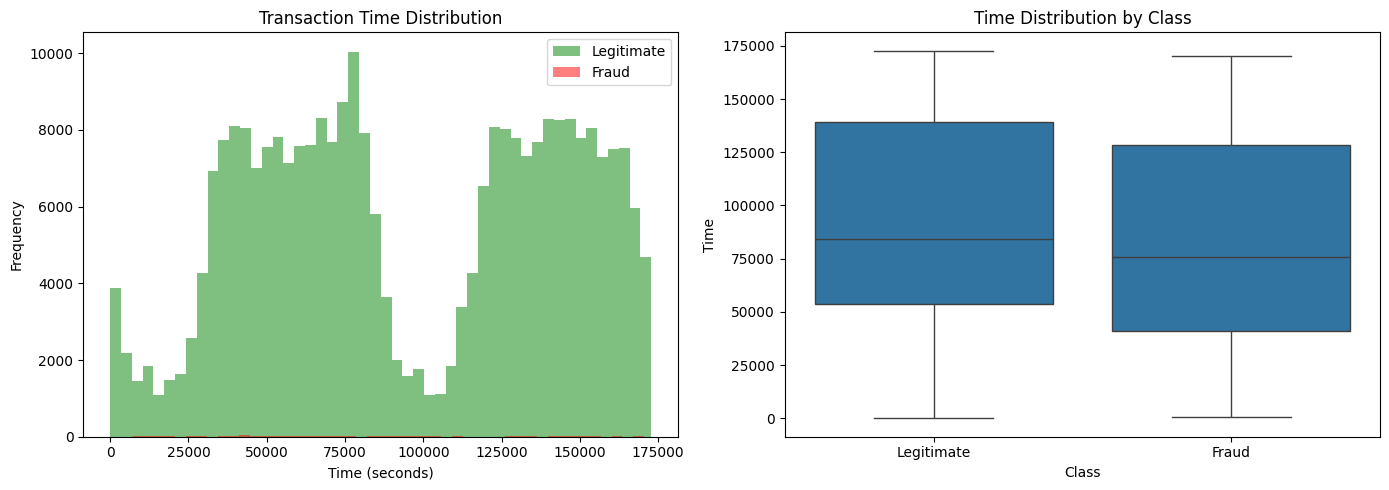

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(df[df['Class']==0]['Time'], bins=50, alpha=0.5, label='Legitimate', color='green')
axes[0].hist(df[df['Class']==1]['Time'], bins=50, alpha=0.5, label='Fraud', color='red')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Transaction Time Distribution')
axes[0].legend()

df_sample = pd.concat([
    df[df['Class']==0].sample(min(5000, len(df[df['Class']==0]))),
    df[df['Class']==1]
])
sns.boxplot(x='Class', y='Time', data=df_sample, ax=axes[1])
axes[1].set_xticklabels(['Legitimate', 'Fraud'])
axes[1].set_title('Time Distribution by Class')

plt.tight_layout()
plt.show()

There are no clear peak hours for the fraudulent transactions unlike the legitimate ones, so we need to capture the subtle details using other methods.

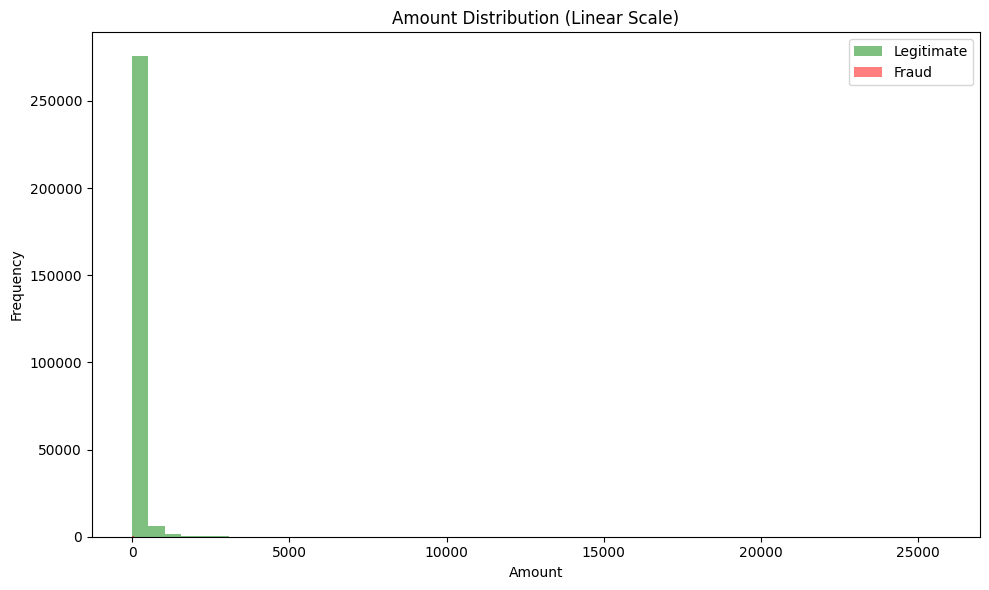

In [8]:
legitimate = df[df['Class']==0]['Amount']
fraud = df[df['Class']==1]['Amount']

plt.figure(figsize=(10, 6))
plt.hist(legitimate, bins=50, alpha=0.5, label='Legitimate', color='green')
plt.hist(fraud, bins=50, alpha=0.5, label='Fraud', color='red')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution (Linear Scale)')
plt.legend()
plt.tight_layout()
plt.show()

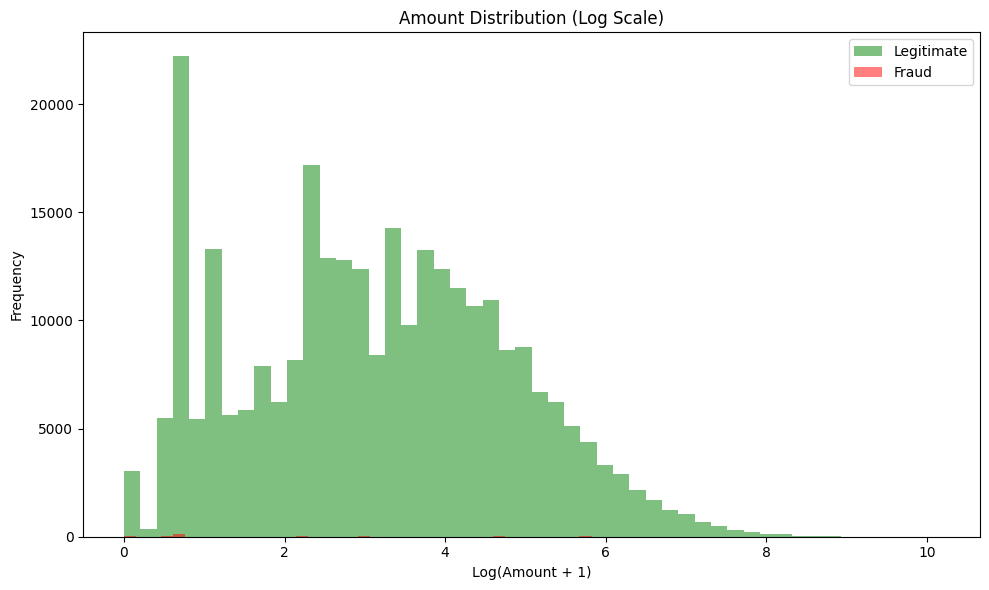

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(legitimate.apply(np.log1p), bins=50, alpha=0.5, label='Legitimate', color='green')
plt.hist(fraud.apply(np.log1p), bins=50, alpha=0.5, label='Fraud', color='red')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')
plt.title('Amount Distribution (Log Scale)')
plt.legend()
plt.tight_layout()
plt.show()

The fraudulent transactions are very distributed and do not follow any sort of pattern.

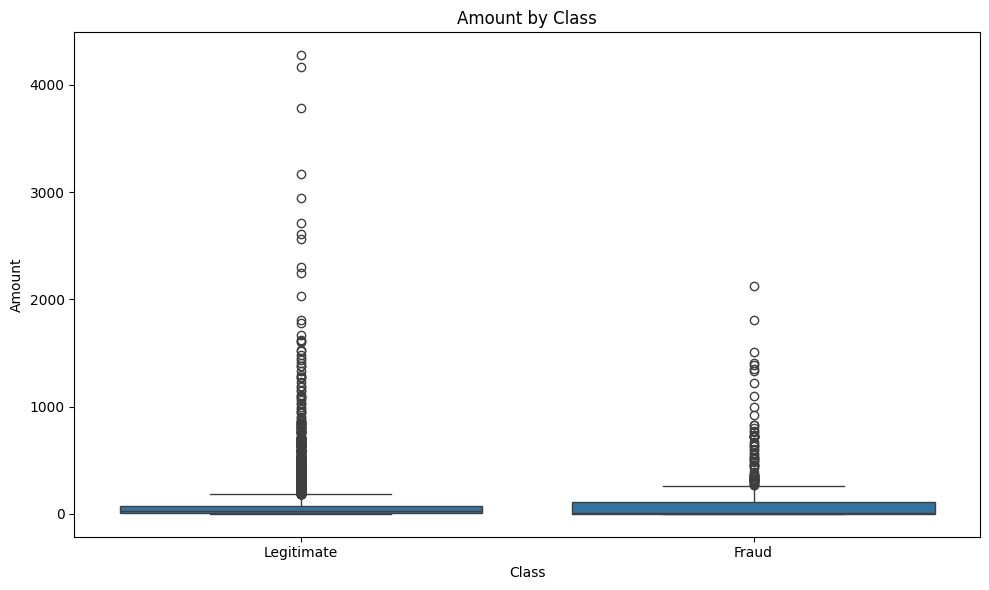

In [10]:
sample_data = pd.concat([
    df[df['Class']==0].sample(min(5000, len(df[df['Class']==0]))),
    df[df['Class']==1]
])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=sample_data)
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.title('Amount by Class')
plt.tight_layout()
plt.show()

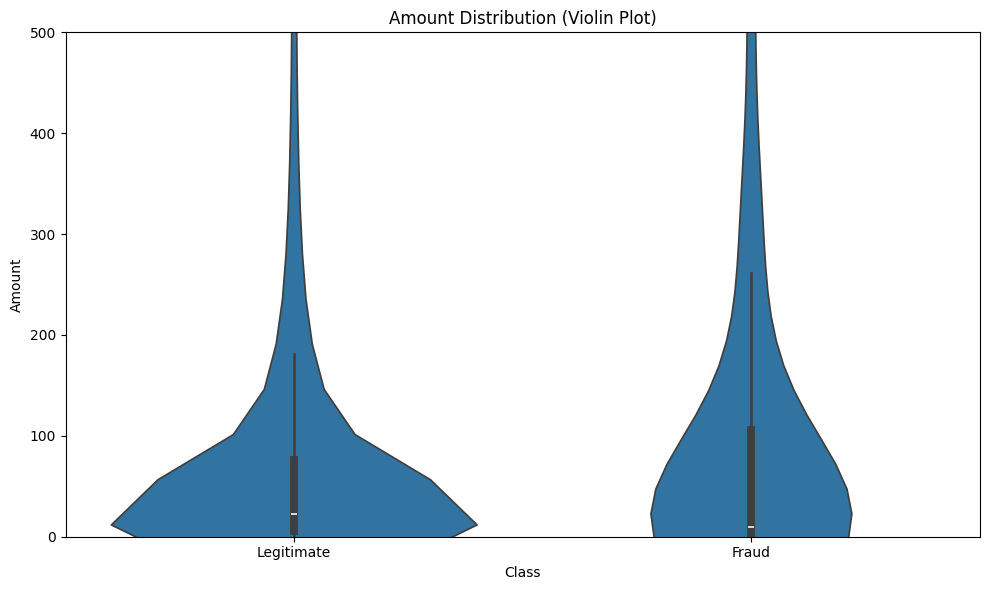

In [11]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Class', y='Amount', data=sample_data)
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.title('Amount Distribution (Violin Plot)')
plt.ylim(0, 500)
plt.tight_layout()
plt.show()

It comes to our notice that the legitimate ones have a thick shape at low values, but the fraud ones have a sort of uniform distribution.

We can now check the PCA features to look for features that correlate well with the target.

In [12]:
v_features = [col for col in df.columns if col.startswith('V')]
print(f"\nNumber of PCA features: {len(v_features)}")

correlations = df[v_features + ['Class']].corr()['Class'].drop('Class').sort_values(ascending=False)
print(f"\nTop 10 Features Most Correlated with Fraud:")
print(correlations.abs().sort_values(ascending=False).head(10))


Number of PCA features: 28

Top 10 Features Most Correlated with Fraud:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64

Top 10 Features Most Correlated with Fraud:
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


We can check the features with the highest correlation to understand if they can be used to train the model.

C:\Users\itsha\AppData\Local\Temp\ipykernel_11704\3717994757.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(['Legitimate', 'Fraud'])
C:\Users\itsha\AppData\Local\Temp\ipykernel_11704\3717994757.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(['Legitimate', 'Fraud'])
C:\Users\itsha\AppData\Local\Temp\ipykernel_11704\3717994757.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(['Legitimate', 'Fraud'])
C:\Users\itsha\AppData\Local\Temp\ipykernel_11704\3717994757.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(['Legitimate', 'Fraud'])
C:\U

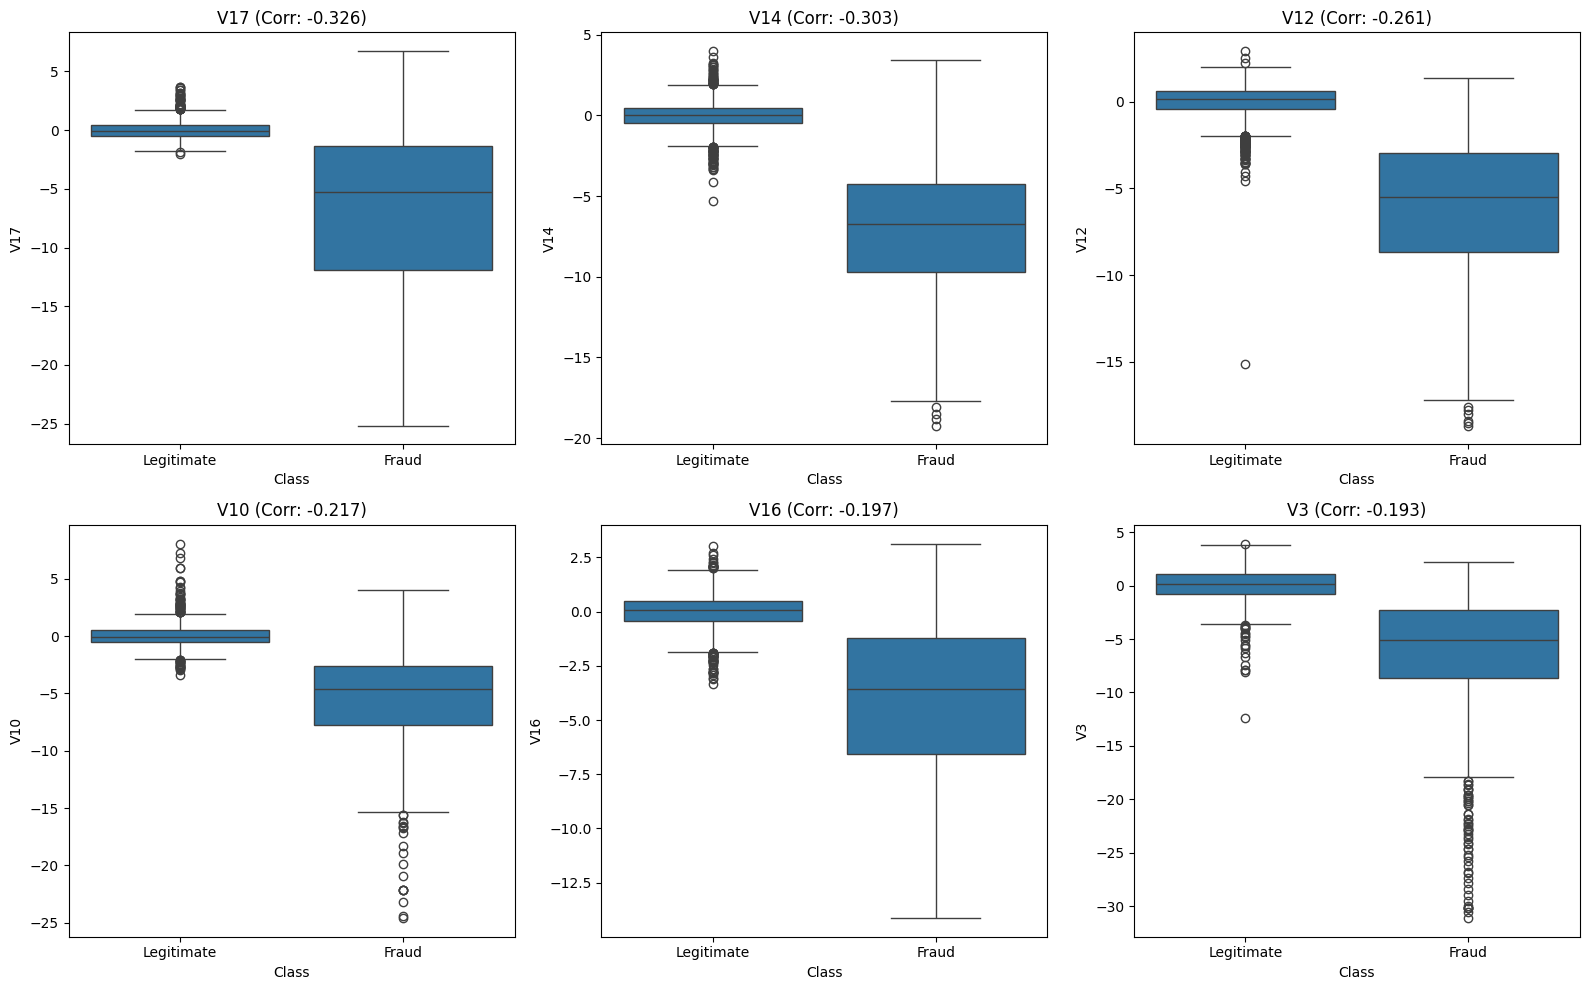

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

top_features = correlations.abs().sort_values(ascending=False).head(6).index

for idx, feature in enumerate(top_features):
    df_sample = pd.concat([
        df[df['Class']==0].sample(min(2000, len(df[df['Class']==0]))),
        df[df['Class']==1]
    ])
    
    sns.boxplot(x='Class', y=feature, data=df_sample, ax=axes[idx])
    axes[idx].set_xticklabels(['Legitimate', 'Fraud'])
    axes[idx].set_title(f'{feature} (Corr: {correlations[feature]:.3f})')

plt.tight_layout()
plt.show()

We can see that lower the values of these features, higher will be the fraud probability. There is minimal overlap between legit and fraud transactions indicating these are good features.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

print(f"\nOriginal Feature Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

scaler = StandardScaler()
X['Time_scaled'] = scaler.fit_transform(X[['Time']])
X['Amount_scaled'] = scaler.fit_transform(X[['Amount']])

X = X.drop(['Time', 'Amount'], axis=1)

print(f"\nFeatures after engineering: {X.columns.tolist()}")
print(f"Final Feature Shape: {X.shape}")


Original Feature Shape: (284807, 30)
Target Shape: (284807,)

Features after engineering: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Time_scaled', 'Amount_scaled']
Final Feature Shape: (284807, 30)


In [15]:
print("TRAIN/VALIDATION/TEST SPLIT")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nTrain Set: {X_train.shape[0]:,}")
print(f"Legitimate: {(y_train==0).sum():,}")
print(f"Fraud: {(y_train==1).sum():,}")

print(f"\nValidation Set: {X_val.shape[0]:,}")
print(f"Legitimate: {(y_val==0).sum():,}")
print(f"Fraud: {(y_val==1).sum():,}")
print(f"\nTest Set: {X_test.shape[0]:,}")
print(f"Legitimate: {(y_test==0).sum():,}")
print(f"Fraud: {(y_test==1).sum():,}")

TRAIN/VALIDATION/TEST SPLIT

Train Set: 170,883
Legitimate: 170,588
Fraud: 295

Validation Set: 56,962
Legitimate: 56,863
Fraud: 99

Test Set: 56,962
Legitimate: 56,864
Fraud: 98

Train Set: 170,883
Legitimate: 170,588
Fraud: 295

Validation Set: 56,962
Legitimate: 56,863
Fraud: 99

Test Set: 56,962
Legitimate: 56,864
Fraud: 98


In [38]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import time

contamination_rate = y_train.sum() / len(y_train)

iso_forest = IsolationForest(
    n_estimators=100,           
    max_samples='auto',         
    contamination=contamination_rate, 
    max_features=1.0,           
    bootstrap=False,            
    n_jobs=-1,                  
    random_state=42,
    verbose=1
)

start_time = time.time()
iso_forest.fit(X_train)
training_time = time.time() - start_time

print(f"Model trained in {training_time:.2f} seconds")


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.2s remaining:    2.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.2s remaining:    2.2s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


Model trained in 1.20 seconds


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [39]:
start_time = time.time()
y_train_pred = iso_forest.predict(X_train)
y_val_pred = iso_forest.predict(X_val)
y_test_pred = iso_forest.predict(X_test)
prediction_time = time.time() - start_time

y_train_pred = (y_train_pred == -1).astype(int)
y_val_pred = (y_val_pred == -1).astype(int)
y_test_pred = (y_test_pred == -1).astype(int)

train_scores = iso_forest.decision_function(X_train)
val_scores = iso_forest.decision_function(X_val)
test_scores = iso_forest.decision_function(X_test)

print(f"  Mean: {test_scores.mean():.4f}")
print(f"  Std: {test_scores.std():.4f}")
print(f"  Min: {test_scores.min():.4f}")
print(f"  Max: {test_scores.max():.4f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: 

  Mean: 0.2571
  Std: 0.0433
  Min: -0.0969
  Max: 0.3173


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


 Precision: 0.3017
 Recall:    0.3017
 F1-Score:  0.3017
 ROC-AUC:   0.9526
 PR-AUC:    0.2057

Confusion Matrix:
 True Negatives (TN):  170,382
 False Positives (FP): 206
 False Negatives (FN): 206
 True Positives (TP):  89


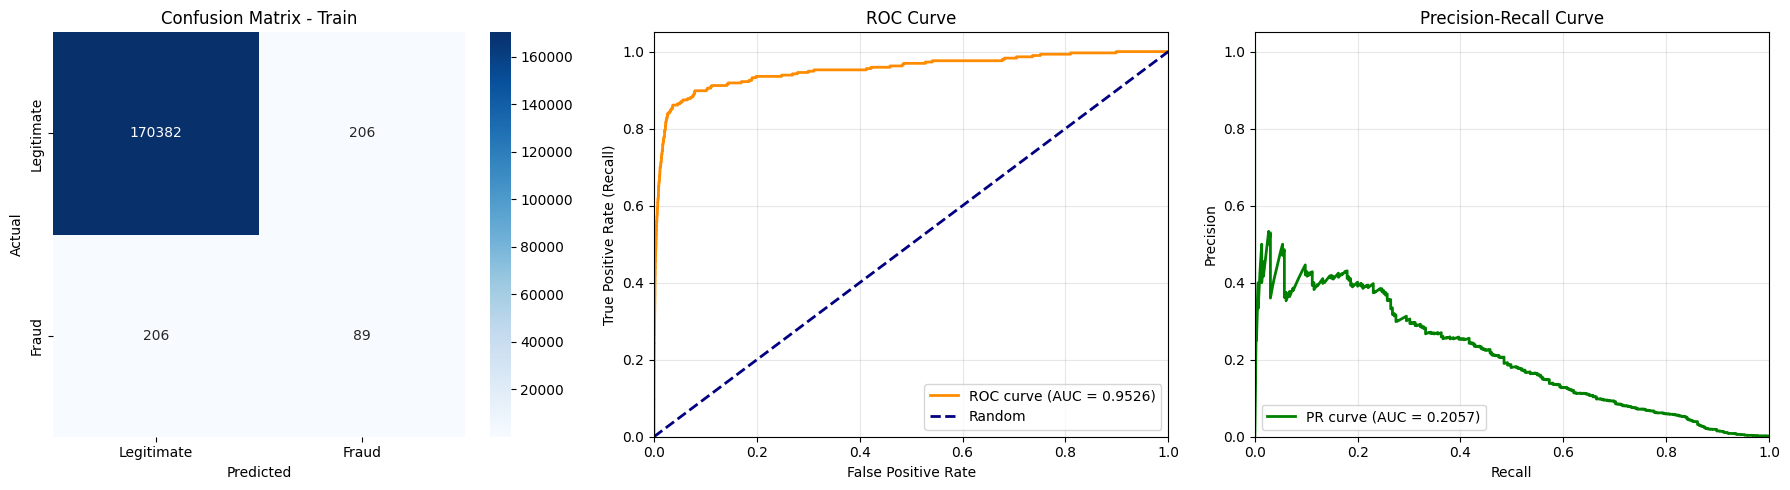

 Precision: 0.2396
 Recall:    0.2323
 F1-Score:  0.2359
 ROC-AUC:   0.9496
 PR-AUC:    0.1397

Confusion Matrix:
 True Negatives (TN):  56,790
 False Positives (FP): 73
 False Negatives (FN): 76
 True Positives (TP):  23


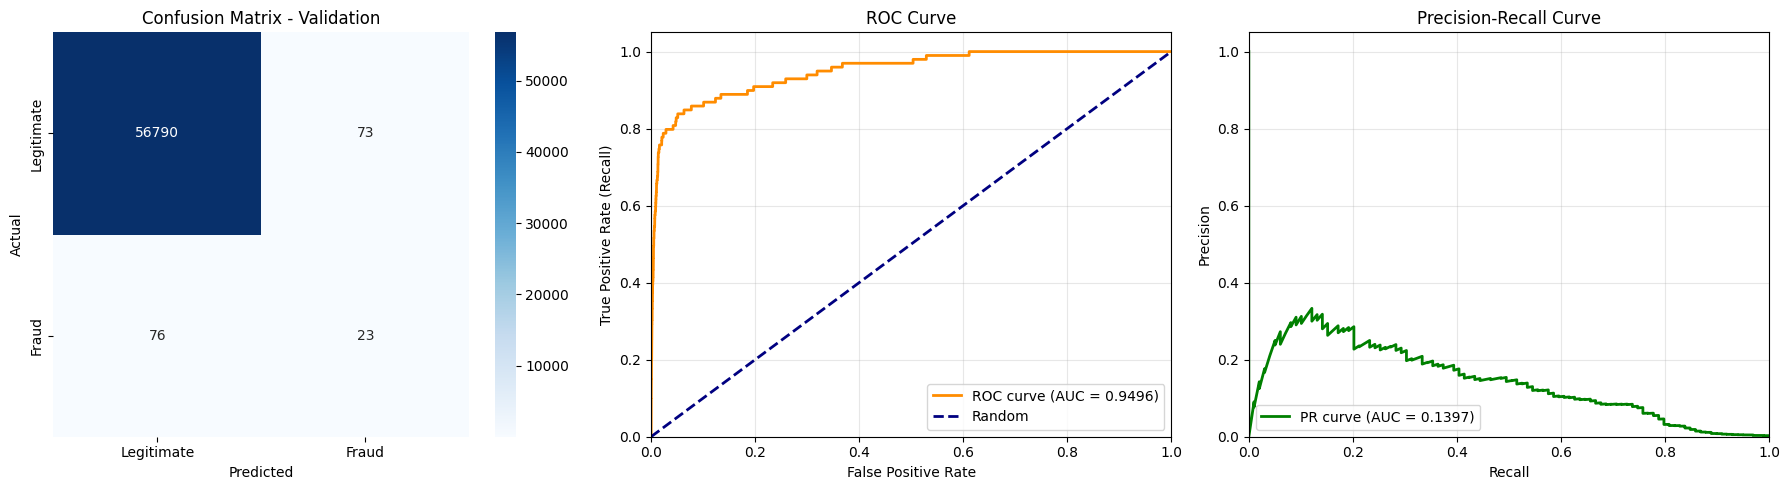

 Precision: 0.2679
 Recall:    0.3061
 F1-Score:  0.2857
 ROC-AUC:   0.9529
 PR-AUC:    0.1975

Confusion Matrix:
 True Negatives (TN):  56,782
 False Positives (FP): 82
 False Negatives (FN): 68
 True Positives (TP):  30


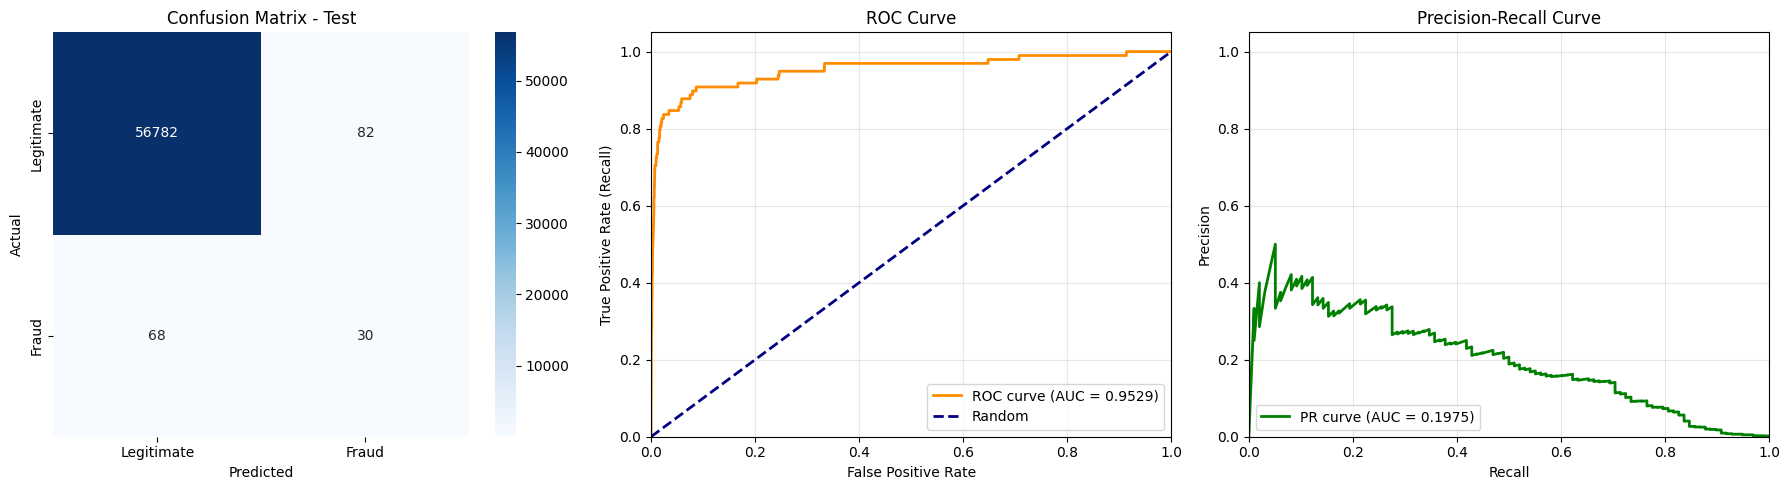

In [40]:
def evaluate_model(y_true, y_pred, scores, dataset_name="Test"):
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, -scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, -scores)
    pr_auc = auc(recall_curve, precision_curve)
    

    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1-Score:  {f1:.4f}")
    print(f" ROC-AUC:   {roc_auc:.4f}")
    print(f" PR-AUC:    {pr_auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix:")
    print(f" True Negatives (TN):  {tn:,}")
    print(f" False Positives (FP): {fp:,}")
    print(f" False Negatives (FN): {fn:,}")
    print(f" True Positives (TP):  {tp:,}")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    axes[0].set_title(f'Confusion Matrix - {dataset_name}')
    
    fpr, tpr, _ = roc_curve(y_true, -scores)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate (Recall)')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)
    
    axes[2].plot(recall_curve, precision_curve, color='green', lw=2, 
                 label=f'PR curve (AUC = {pr_auc:.4f})')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend(loc="lower left")
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }
train_metrics = evaluate_model(y_train, y_train_pred, train_scores, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, val_scores, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, test_scores, "Test")

ROC-AUC scores are good, which means the model is able to differentiate well, but it has really low precision. The PR-AUC score is really low and hence the model would perform poorly in a real-world scenario without threshold optimization.

The threshold needs to be optimized in order to get a better precision score.

Threshold Optimization

Optimal Threshold (Max F1-Score): 0.0838
Precision: 0.1035
Recall: 0.5960
F1-Score: 0.1764

Optimal Threshold (Max F1-Score): 0.0838
Precision: 0.1035
Recall: 0.5960
F1-Score: 0.1764


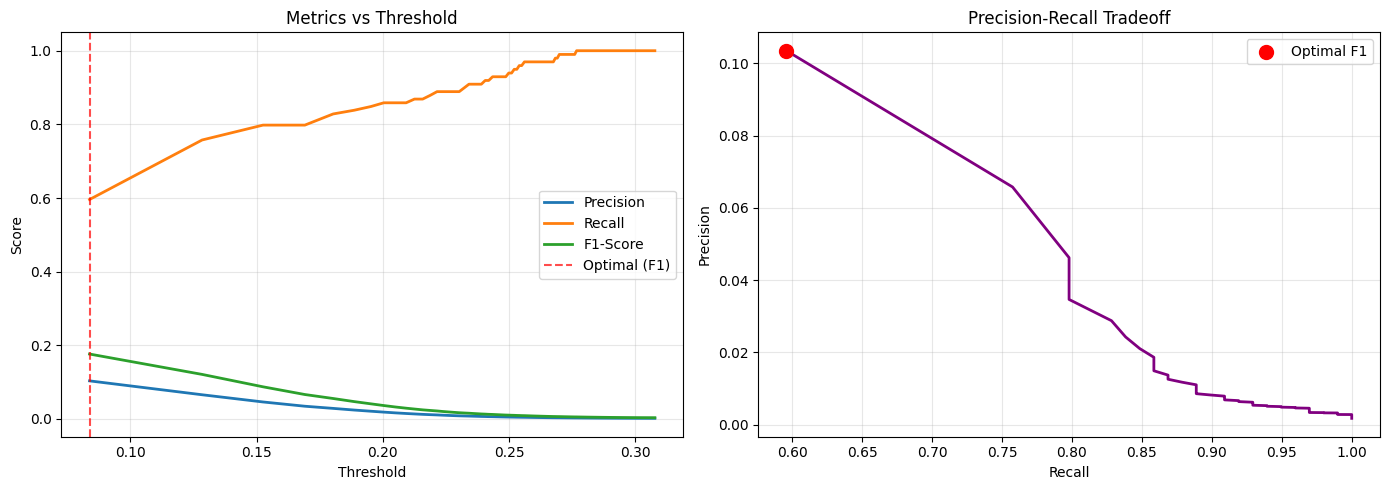

In [42]:
print("Threshold Optimization")

thresholds = np.percentile(val_scores, np.arange(0, 100, 1))

results = []
for threshold in thresholds:
    y_pred_threshold = (val_scores < threshold).astype(int)
    
    if y_pred_threshold.sum() > 0:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)
        recall = recall_score(y_val, y_pred_threshold, zero_division=0)
        f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

results_df = pd.DataFrame(results)

optimal_f1_idx = results_df['f1'].idxmax()
optimal_f1_threshold = results_df.loc[optimal_f1_idx, 'threshold']

print(f"\nOptimal Threshold (Max F1-Score): {optimal_f1_threshold:.4f}")
print(f"Precision: {results_df.loc[optimal_f1_idx, 'precision']:.4f}")
print(f"Recall: {results_df.loc[optimal_f1_idx, 'recall']:.4f}")
print(f"F1-Score: {results_df.loc[optimal_f1_idx, 'f1']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], label='F1-Score', linewidth=2)
axes[0].axvline(optimal_f1_threshold, color='red', linestyle='--', label=f'Optimal (F1)', alpha=0.7)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(results_df['recall'], results_df['precision'], linewidth=2, color='purple')
axes[1].scatter(results_df.loc[optimal_f1_idx, 'recall'], 
                results_df.loc[optimal_f1_idx, 'precision'], 
                color='red', s=100, zorder=5, label='Optimal F1')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Tradeoff')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Test Set Evaluation with Optimal Threshold
 Precision: 0.1149
 Recall:    0.7143
 F1-Score:  0.1980
 ROC-AUC:   0.9529
 PR-AUC:    0.1975

Confusion Matrix:
 True Negatives (TN):  56,325
 False Positives (FP): 539
 False Negatives (FN): 28
 True Positives (TP):  70


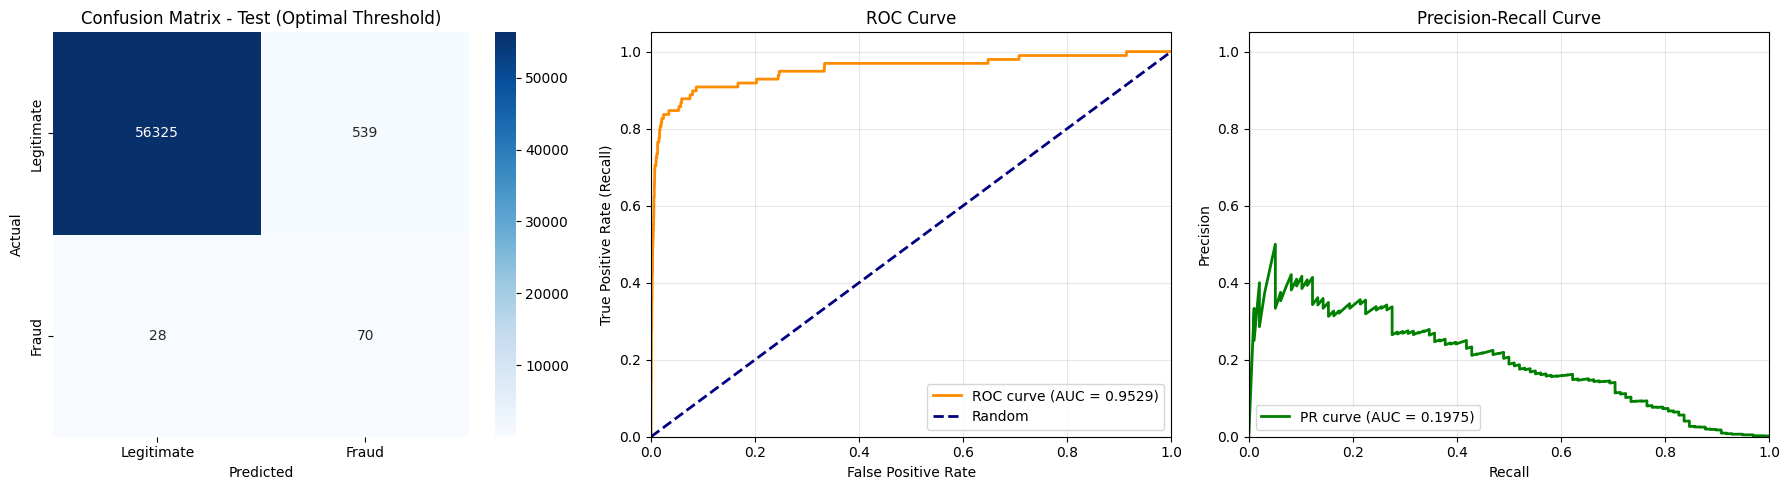

In [44]:
print("Test Set Evaluation with Optimal Threshold")

y_test_pred_optimal = (test_scores < optimal_f1_threshold).astype(int)
test_metrics_optimal = evaluate_model(y_test, y_test_pred_optimal, test_scores, "Test (Optimal Threshold)")

In [22]:
# finding a better threshold with 70-80% recall
recall_min = 0.70
recall_max = 0.85

candidates = results_df[(results_df['recall'] >= recall_min) & (results_df['recall'] <= recall_max)]

if len(candidates) > 0:
    best_idx = candidates['precision'].idxmax()
    balanced_threshold = results_df.loc[best_idx, 'threshold']
    
    print("\nBalanced Threshold:")
    print(f"Threshold: {balanced_threshold:.4f}")
    print(f"Precision: {results_df.loc[best_idx, 'precision']:.4f}")
    print(f"Recall: {results_df.loc[best_idx, 'recall']:.4f}")
    print(f"F1: {results_df.loc[best_idx, 'f1']:.4f}")
else:
    print("no threshold found in target range, using max F1")
    balanced_threshold = optimal_f1_threshold


Balanced Threshold:
Threshold: 0.1284
Precision: 0.0658
Recall: 0.7576
F1: 0.1211



Comparing approaches:
------------------------------------------------------------

1. Max F1 (0.0838):
   P=10.4%, R=59.6%, F1=17.6%
   58 frauds caught, 502 false alarms

2. Balanced (0.1284):
   P=6.6%, R=75.8%, F1=12.1%
   75 frauds caught, 1065 false alarms


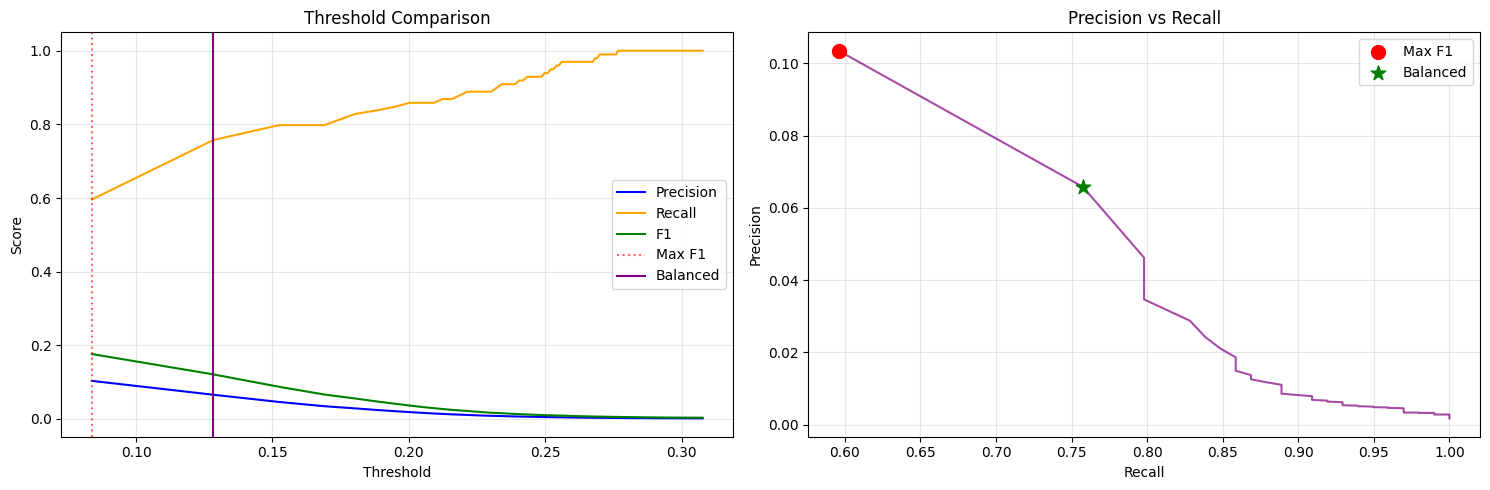

In [23]:
print("\nComparing approaches:")
print("-" * 60)

print(f"\n1. Max F1 ({optimal_f1_threshold:.4f}):")
p = results_df.loc[optimal_f1_idx, 'precision']
r = results_df.loc[optimal_f1_idx, 'recall']
f = results_df.loc[optimal_f1_idx, 'f1']
print(f"   P={p*100:.1f}%, R={r*100:.1f}%, F1={f*100:.1f}%")

total_fraud = y_val.sum()
caught = int(total_fraud * r)
flagged = int(caught / p) if p > 0 else 0
fp = flagged - caught
print(f"   {caught} frauds caught, {fp} false alarms")

print(f"\n2. Balanced ({balanced_threshold:.4f}):")
bp = results_df.loc[best_idx, 'precision']
br = results_df.loc[best_idx, 'recall']
bf = results_df.loc[best_idx, 'f1']
print(f"   P={bp*100:.1f}%, R={br*100:.1f}%, F1={bf*100:.1f}%")

b_caught = int(total_fraud * br)
b_flagged = int(b_caught / bp) if bp > 0 else 0
b_fp = b_flagged - b_caught
print(f"   {b_caught} frauds caught, {b_fp} false alarms")

# plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision')
ax1.plot(results_df['threshold'], results_df['recall'], 'orange', label='Recall')
ax1.plot(results_df['threshold'], results_df['f1'], 'g-', label='F1')
ax1.axvline(optimal_f1_threshold, color='r', linestyle=':', alpha=0.6, label='Max F1')
ax1.axvline(balanced_threshold, color='purple', linestyle='-', linewidth=1.5, label='Balanced')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Threshold Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(results_df['recall'], results_df['precision'], 'purple', linewidth=1.5, alpha=0.7)
ax2.scatter(r, p, color='red', s=100, label='Max F1', zorder=3)
ax2.scatter(br, bp, color='green', s=120, marker='*', label='Balanced', zorder=3)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision vs Recall')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Final Results
 Precision: 0.0661
 Recall:    0.8163
 F1-Score:  0.1223
 ROC-AUC:   0.9529
 PR-AUC:    0.1975

Confusion Matrix:
 True Negatives (TN):  55,734
 False Positives (FP): 1,130
 False Negatives (FN): 18
 True Positives (TP):  80


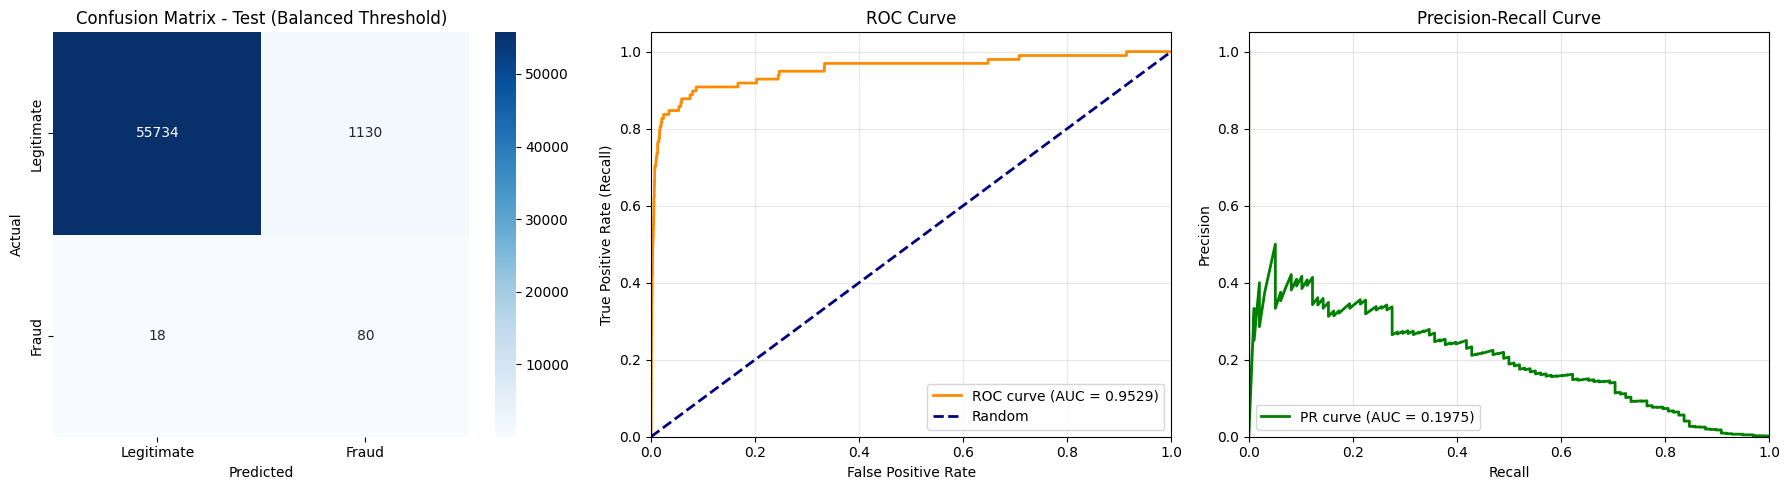


Final Test Results:
Using threshold: 0.1284
Precision: 6.6%
Recall: 81.6%
F1: 12.2%
ROC-AUC: 95.3%
PR-AUC: 19.7%


In [45]:
print("Final Results")

y_test_pred_balanced = (test_scores < balanced_threshold).astype(int)
test_metrics_balanced = evaluate_model(y_test, y_test_pred_balanced, test_scores, "Test (Balanced Threshold)")

print("\nFinal Test Results:")
print(f"Using threshold: {balanced_threshold:.4f}")
print(f"Precision: {test_metrics_balanced['precision']*100:.1f}%")
print(f"Recall: {test_metrics_balanced['recall']*100:.1f}%")
print(f"F1: {test_metrics_balanced['f1']*100:.1f}%")
print(f"ROC-AUC: {test_metrics_balanced['roc_auc']*100:.1f}%")
print(f"PR-AUC: {test_metrics_balanced['pr_auc']*100:.1f}%")

optimal_f1_threshold = balanced_threshold
test_metrics_optimal = test_metrics_balanced

Going with the balanced model is the way to go because it catches 82 percent of the frauds with 1130 false alarms, which are manageable. The low precision is unavoidable when fraud is this rare.

In [47]:
import pickle
import json
from datetime import datetime
import os

notebook_dir = os.getcwd()
models_dir = os.path.join(notebook_dir, 'models')
os.makedirs(models_dir, exist_ok=True)

print("Saving Model Artifacts")

model_path = os.path.join(models_dir, 'isolation_forest_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(iso_forest, f)
print(f"Model saved to: {model_path}")

scaler_path = os.path.join(models_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to: {scaler_path}")

metadata = {
    'model_type': 'IsolationForest',
    'training_date': datetime.now().isoformat(),
    'n_samples_train': len(X_train),
    'n_features': X_train.shape[1],
    'optimal_threshold': float(optimal_f1_threshold),
    'contamination_rate': float(contamination_rate),
    'test_metrics': {
        'precision': float(test_metrics_optimal['precision']),
        'recall': float(test_metrics_optimal['recall']),
        'f1_score': float(test_metrics_optimal['f1']),
        'roc_auc': float(test_metrics_optimal['roc_auc']),
        'pr_auc': float(test_metrics_optimal['pr_auc'])
    },
    'model_parameters': iso_forest.get_params()
}

metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"Metadata saved to: {metadata_path}")

print(f"All artifacts saved to: {models_dir}")

Saving Model Artifacts
Model saved to: c:\Users\itsha\Desktop\github_repo\fault_detection\models\isolation_forest_model.pkl
Scaler saved to: c:\Users\itsha\Desktop\github_repo\fault_detection\models\scaler.pkl
Metadata saved to: c:\Users\itsha\Desktop\github_repo\fault_detection\models\model_metadata.json
All artifacts saved to: c:\Users\itsha\Desktop\github_repo\fault_detection\models
